L'équipe pour réaliser ce projet est constituée de : Thomas Bodart, Maceo Duriez et Marc-César Garcia-Grenet

Vous trouverez ci-dessous les deux configurations (continuous_actions et stable_baselines) que nous avons retenues pour le projet.

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import time
from tqdm import tqdm
import highway_env
import torch
import torch.nn as nn
from copy import deepcopy

In [ ]:
%matplotlib inline
def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)
    done = False
    state, _ = display_env.reset()

    rewards = 0

    while not done:
        action = agent.get_action(state, epsilon=0)
        state, reward, done, _, _ = display_env.step(action)
        rewards += reward
        if display: 
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
    if display:
        display_env.close()
    print(f'Episode length {rewards}')

def eval_agent(agent, env, n_sim=10):
    """    
    Monte Carlo evaluation of the agent.

    Repeat n_sim times:
        * Run the agent policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done: 
            action = agent.get_action(state, epsilon=0)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards

def train(env, agent, N_episodes, eval_every=100, reward_threshold=300, n_eval=10):
    total_time = 0
    for ep in tqdm(range(N_episodes), desc="Training..."):
        done = False
        state, _ = env.reset()
        while not done: 
            action = agent.get_action(state)

            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.update(state, action, reward, terminated, next_state)

            state = next_state

            done = terminated or truncated
            total_time += 1

        if ((ep+1)% eval_every == 0):
            mean_reward = np.mean(eval_agent(agent, env, n_sim=n_eval))
            print("episode =", ep+1, ", reward = ", mean_reward)
            if mean_reward >= reward_threshold:
                break
                
    return 

class RandomAgent: 
    def __init__(self, observation_space, action_space):
        self.action_space = action_space
        return
    
    def get_action(self, state, **kwargs):
        return self.action_space.sample()
    
    def update(self, *data):
        pass

# Task 1: Pre-specified environment
Let us first define the environment

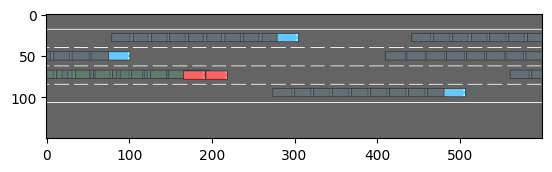

Episode length 13.526325725238394


In [3]:

config_dict = {
    "observation": {
        "type": "OccupancyGrid",
        "vehicles_count": 10,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20],
        },
        "grid_size": [[-20, 20], [-20, 20]],
        "grid_step": [5, 5],
        "absolute": False,
    },
    "action": {
        "type": "DiscreteMetaAction",
    },
    "lanes_count": 4,
    "vehicles_count": 15,
    "duration": 60,  # [s]
    "initial_spacing": 0,
    "collision_reward": -1,  # The reward received when colliding with a vehicle.
    "right_lane_reward": 0.5,  # The reward received when driving on the right-most lanes, linearly mapped to
    # zero for other lanes.
    "high_speed_reward": 0.1,  # The reward received when driving at full speed, linearly mapped to zero for
    # lower speeds according to config["reward_speed_range"].
    "lane_change_reward": 0,
    "reward_speed_range": [
        20,
        30,
    ],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD].
    "simulation_frequency": 5,  # [Hz]
    "policy_frequency": 1,  # [Hz]
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "screen_width": 600,  # [px]
    "screen_height": 150,  # [px]
    "centering_position": [0.3, 0.5],
    "scaling": 5.5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
    "disable_collision_checks": True,
}

env = gym.make("highway-fast-v0", render_mode="rgb_array", config = config_dict)
env.reset()


run_one_episode(env, RandomAgent(env.observation_space, env.action_space))

## General comments on the environment
### Observation space:
The observation space is a 8x8 grid, with the following channels (as in image):
- Presence: 1 if a car is here, 0 otherwise
- x and y: relative position
- vx, vy: relative velocities
- cos_h, sin_h: angle

### Action space:
There is 5 possible actions:
- IDLE: do nothing
- LEFT: go left
- RIGHT: go right
- FASTER: go faster
- SLOWER: go slower


In [4]:
print("Observation space shape: ", env.observation_space.shape)
print("Action space shape", env.action_space)


Observation space shape:  (7, 8, 8)
Action space shape Discrete(5)


## DQN Implementation
### Neural Network
Let us define the neural network for DQN. Since the observation space looks like an 8x8 image (with 7 channels), we will use CNN

In [5]:
class CNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels=7, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 5)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
    
    def forward(self, observation_space:torch.FloatTensor):
        x = self.relu(self.conv1(observation_space))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flatten(self.flatten(x))
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
ex = torch.tensor([env.observation_space.sample()])
model = CNN()
model(ex)

/var/folders/c1/j3mjhbjn00x3fcz1qgkn682h0000gn/T/ipykernel_36178/1167295926.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  ex = torch.tensor([env.observation_space.sample()])


tensor([[ 0.0053, -0.0535, -0.0043,  0.0244, -0.0535]],
       grad_fn=<AddmmBackward0>)

### Agent
Let us now define the agent. 

In [11]:
class DQNAgent:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        episode_batch_size,
        learning_rate,
        weight_decay,
        model,
        optimizer,
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        
        self.n_eps = 0
        self.scores = []
        self.current_episode = []


        self.episode_batch_size = episode_batch_size
        self.learning_rate = learning_rate
        self.device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

        self.policy_net = model.to(self.device)
        

        self.optimizer = optimizer(self.policy_net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    def _gradient_returns_with_mean_goal(self, rewards, gamma):
        """
        Turns a list of rewards into the list of returns * gamma**t
        """
        mean_goal = self._mean_goal(rewards, gamma)
        G = 0
        returns_list = []
        T = len(rewards)
        full_gamma = np.power(gamma, T)
        for t in range(T):
            G = rewards[T-t-1] + gamma * G
            full_gamma /= gamma
            returns_list.append(full_gamma * (G - mean_goal))
        return torch.tensor(returns_list[::-1]).to(self.device)
    
    def _mean_goal(self, rewards, gamma):
        T = len(rewards)
        G = torch.zeros(T)
        for t in range(T-2, -1, -1):
            G[t] = rewards[t + 1] + gamma * G[t + 1]
        return G.mean()

    def update(self, state, action, reward, terminated, next_state):
        self.current_episode.append((
            torch.tensor(state, device=self.device).unsqueeze(0),
            torch.tensor([[action]], dtype=torch.int64, device=self.device),
            torch.tensor([reward], dtype=torch.float32, device=self.device),
        )
        )

        if terminated:
            states, actions, rewards = [torch.cat(a) for a in zip(*self.current_episode)]
            returns = self._gradient_returns_with_mean_goal(rewards, self.gamma)

            logits = self.policy_net(states)
            log_probs = logits.log_softmax(dim=-1)
            selected_log_probs = torch.gather(log_probs, 1, actions).squeeze()

            if not hasattr(self, 'batch_returns'):
                self.batch_returns = []
                self.batch_log_probs = []

            self.batch_returns.extend(returns)
            self.batch_log_probs.extend(selected_log_probs)


            if (self.n_eps % self.episode_batch_size) == 0:
                batch_returns = torch.stack(self.batch_returns)
                batch_log_probs = torch.stack(self.batch_log_probs)

                loss = -(batch_returns * batch_log_probs).mean()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()


                self.batch_returns = []
                self.batch_log_probs = []
            
            self.current_episode = []    

    def get_action(self, state, epsilon=None):
        
        state_tensor = torch.tensor(state, device=self.device).unsqueeze(0)
        with torch.no_grad():
            logits:torch.FloatTensor = self.policy_net(state_tensor)
            probabilities = logits.softmax(dim=-1)
            action = torch.multinomial(probabilities, num_samples=1).item()
            return action


In [ ]:
env = gym.make("highway-fast-v0", render_mode="rgb_array", config = config_dict)
env.reset()

action_space = env.action_space
observation_space = env.observation_space

gamma = .95
episode_batch_size = 64
learning_rate = 1e-2
weight_decay = 1e-4
model=CNN()
optimizer = torch.optim.AdamW
N_episodes = 1000

agent = DQNAgent(
    action_space=action_space,
    observation_space=observation_space,
    gamma=gamma,
    episode_batch_size=episode_batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    model=model,
    optimizer=optimizer,
)

print("mean reward before training = ", np.mean(eval_agent(agent, env, 10)))
# Run the training loop
train(env, agent, N_episodes, eval_every=50,)

# Evaluate the final policy
print("mean reward after training = ", np.mean(eval_agent(agent, env, 10)))

mean reward before training =  8.492466843469796
episode = 50 , reward =  47.01098220006083
episode = 100 , reward =  47.716197667359054
episode = 150 , reward =  49.789114336492894
episode = 200 , reward =  52.68807266982624
episode = 250 , reward =  46.254739336492904
episode = 300 , reward =  42.31723933616742
episode = 350 , reward =  43.75473933649288
episode = 400 , reward =  40.28598933649289
episode = 450 , reward =  42.31723933649281
episode = 500 , reward =  42.50473933649289
episode = 550 , reward =  48.1297393364929
episode = 600 , reward =  44.379739336492904


In [ ]:
run_one_episode(env, agent)

# Task 2:

In [7]:
racing_config = {
    'action': {
        'lateral': True,
        'longitudinal': True,
        'target_speeds': [0, 30, 50, 80],
        'type': 'ContinuousAction'
    },
    'action_reward': -0.1,
    'collision_reward': -5,
    'controlled_vehicles': 1,
    'duration': 1200,
    'lane_centering_cost': 1,
    'lane_centering_reward': 0.1,
    'manual_control': False,
    'observation': {
        'align_to_vehicle_axes': True,
        'as_image': False,
        'features': ['presence', 'velocity', 'acceleration'],
        'grid_size': [[-30, 30], [-30, 30]],
        'grid_step': [5, 5],
        'type': 'OccupancyGrid'
    },
    'offscreen_rendering': False,
    'other_vehicles': 3, 
    'other_vehicles_type': 'highway_env.vehicle.behavior.AggressiveVehicle',
    'policy_frequency': 5,
    'real_time_rendering': True,
    'render_agent': True,
    'scaling': 6,
    'screen_height': 800,
    'screen_width': 1200,
    'show_trajectories': False,
    'simulation_frequency': 15,
}

env = gym.make("racetrack-v0", render_mode="rgb_array", config=racing_config)
env.reset()

for _ in range(100):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    env.render()

plt.imshow(env.render())
env.close()

AttributeError: 'NoneType' object has no attribute 'get_image'

In [ ]:
stablebaselines_config = {'action': {'type': 'DiscreteMetaAction'},
'centering_position': [0.3, 0.5],
'collision_reward': -1.0,
'controlled_vehicles': 1,
'duration': 45,
'ego_spacing': 2,
'high_speed_reward': 1.0,
'initial_lane_id': None,
'lane_change_reward': 0.2,
'lanes_count': 4,
'manual_control': False,
'normalize_reward': True,
'observation': {'type': 'Kinematics'},
'offroad_terminal': False,
'offscreen_rendering': False,
'other_vehicles_type': 'highway_env.vehicle.behavior.AggressiveVehicle',
'policy_frequency': 1,
'real_time_rendering': False,
'render_agent': True,
'reward_speed_range': [30, 80],
'right_lane_reward': -0.1,
'scaling': 6.0,
'screen_height': 300,
'screen_width': 1200,
'show_trajectories': False,
'simulation_frequency': 15,
'vehicles_count': 100,
'vehicles_density': 2}

env = gym.make("highway-fast-v0", render_mode="rgb_array", config=stablebaselines_config)
env.reset()

for _ in range(100):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    env.render()

plt.imshow(env.render())
env.close()

AttributeError: 'NoneType' object has no attribute 'get_image'